## Helper functions for making the datasets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])

from functools import reduce
def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))

import itertools
def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()

def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)

## Generating functions for different shapes inside teh image

In [ ]:
def generate_random_data(height, width, count):
    x, y = zip(*[generate_img_and_mask(height, width) for i in range(0, count)])

    X = np.asarray(x) * 255
    X = X.repeat(3, axis=1).transpose([0, 2, 3, 1]).astype(np.uint8)
    Y = np.asarray(y)

    return X, Y

def generate_img_and_mask(height, width):
    shape = (height, width)

    triangle_location = get_random_location(*shape)
    circle_location1 = get_random_location(*shape, zoom=0.7)
    circle_location2 = get_random_location(*shape, zoom=0.5)
    mesh_location = get_random_location(*shape)
    square_location = get_random_location(*shape, zoom=0.8)
    plus_location = get_random_location(*shape, zoom=1.2)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    arr = add_triangle(arr, *triangle_location)
    arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    arr = add_mesh_square(arr, *mesh_location)
    arr = add_filled_square(arr, *square_location)
    arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location1),
         add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        # add_mesh_square(np.zeros(shape, dtype=bool), *mesh_location),
        add_plus(np.zeros(shape, dtype=bool), *plus_location)
    ]).astype(np.float32)

    return arr, masks

def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True

    return arr

def add_filled_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))

def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)

    return new_array

def add_mesh_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))

def add_triangle(arr, x, y, size):
    s = int(size / 2)

    triangle = np.tril(np.ones((size, size), dtype=bool))

    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle

    return arr

def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))

    return new_arr

def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True

    return arr

def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))

    size = int(min(width, height) * random.uniform(0.06, 0.12) * zoom)

    return (x, y, size)

In [ ]:
import pandas as pd

(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


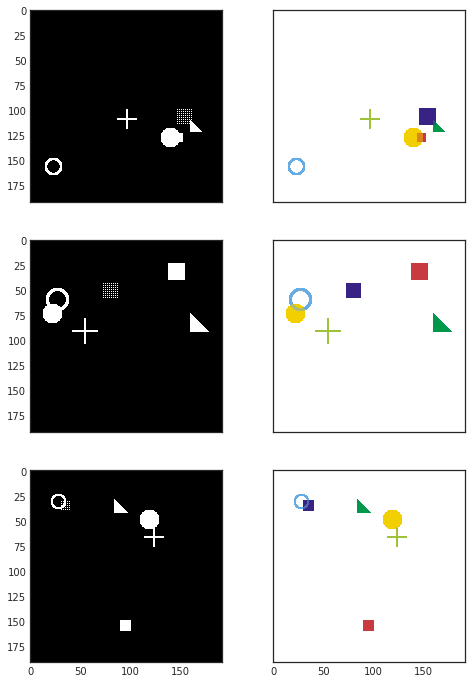

In [ ]:
# Generate some random images
input_images, target_masks = generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask (Ground-truth)
with plt.style.context('seaborn-white'):
    plot_side_by_side([input_images_rgb, target_masks_rgb])

## Creating the custom dataset object

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = generate_random_data(192, 192, count=count)        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
])

train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

torch.Size([25, 3, 192, 192]) torch.Size([25, 6, 192, 192])
0.0 1.0 0.023680555 0.15205191
0.0 1.0 0.004773401 0.06892488


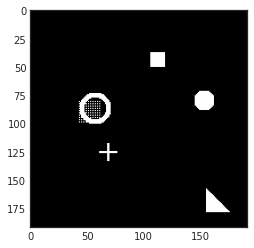

In [ ]:

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

with plt.style.context('seaborn-white'):
  plt.imshow(reverse_transform(inputs[3]))

## The model

In [ ]:
import torch.nn as nn
from torchsummary import summary

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   

        x = self.dconv_up1(x)
        
        out = self.conv_last(x)

        return out

In [ ]:
upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
upsample??

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(6)
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

## Define the loss function

In [ ]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [ ]:
inputs, masks = next(iter(dataloaders['train']))
model = UNet(6)

In [ ]:
inputs.shape, masks.shape

(torch.Size([25, 3, 192, 192]), torch.Size([25, 6, 192, 192]))

In [ ]:
del model; del inputs; del masks;

In [ ]:
# output = model(inputs)
# output.shape

## The training function

In [ ]:
from collections import defaultdict
import torch.nn.functional as F
import torch

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer,  num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                #print('label shape1 : ', labels.shape)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    # print('output shape : ', outputs.shape)
                    # print('label shape : ', labels.shape)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

model = UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft,  num_epochs=40)

cuda:0
Epoch 0/39
----------
LR 0.0001
train: bce: 0.182261, dice: 0.992183, loss: 0.587222
val: bce: 0.024034, dice: 0.944857, loss: 0.484445
saving best model
1m 45s
Epoch 1/39
----------
LR 0.0001
train: bce: 0.022826, dice: 0.779137, loss: 0.400981
val: bce: 0.029321, dice: 0.656941, loss: 0.343131
saving best model
1m 46s
Epoch 2/39
----------
LR 0.0001
train: bce: 0.024485, dice: 0.539615, loss: 0.282050
val: bce: 0.020484, dice: 0.465924, loss: 0.243204
saving best model
1m 46s
Epoch 3/39
----------
LR 0.0001
train: bce: 0.017141, dice: 0.420929, loss: 0.219035
val: bce: 0.016011, dice: 0.376407, loss: 0.196209
saving best model
1m 46s
Epoch 4/39
----------
LR 0.0001
train: bce: 0.014516, dice: 0.359534, loss: 0.187025
val: bce: 0.014085, dice: 0.329607, loss: 0.171846
saving best model
1m 47s
Epoch 5/39
----------
LR 0.0001
train: bce: 0.011665, dice: 0.266867, loss: 0.139266
val: bce: 0.014732, dice: 0.272951, loss: 0.143842
saving best model
1m 47s
Epoch 6/39
----------
LR 0.

(4, 6, 192, 192)


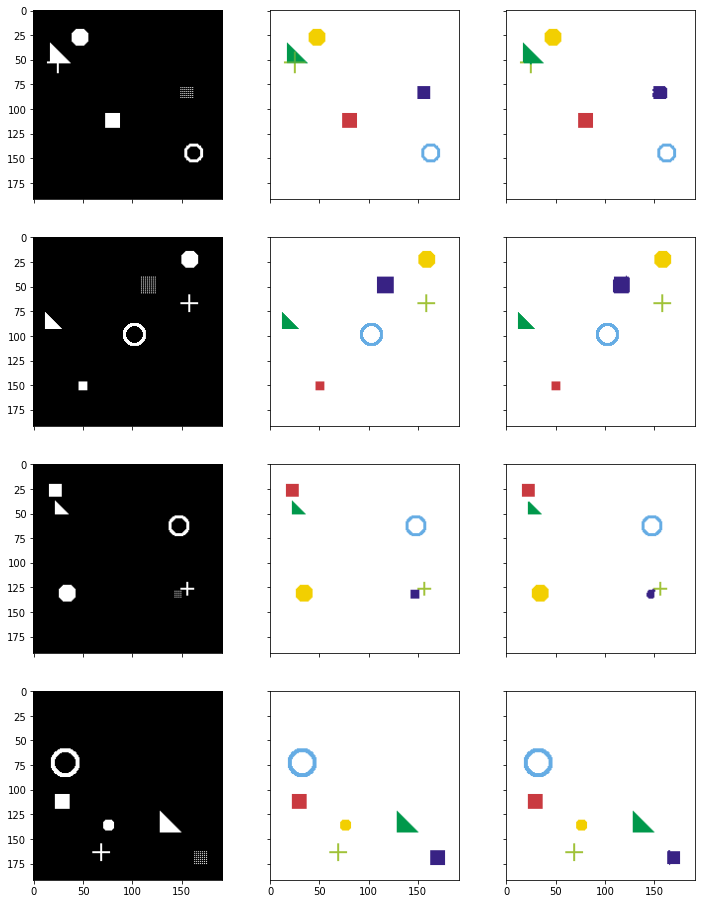

In [ ]:
import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(4, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.detach().cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [masks_to_colorimg(x) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

In [ ]:
nn.Upsample??

Object `nn.Upsample` not found.
